## Lab 3
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [12]:
try:
    import google.colab
    USE_COLAB = True
except:
    USE_COLAB = False

if USE_COLAB:
    print("Don't forget to avoid disconnections:")
    print("""
    function ClickConnect(){
        console.log("Clicking"); 
        document.querySelector("colab-connect-button").click() 
    }
    setInterval(ClickConnect,60000)
    
    """)

Don't forget to avoid disconnections:

    function ClickConnect(){
        console.log("Clicking"); 
        document.querySelector("colab-connect-button").click() 
    }
    setInterval(ClickConnect,60000)
    
    


In [13]:
WORK_DIR = './'
if USE_COLAB:
    from google.colab import files, drive
    WORK_DIR = '/content/drive/'
    drive.mount(WORK_DIR)
    WORK_DIR += 'My Drive/projects/lab-3-overfit-it/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [14]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [15]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [0]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [0]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [18]:
len(fmnist_dataset_test)

10000

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


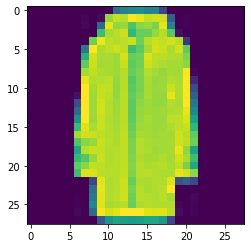

In [19]:
for img, label in train_loader:
    print(img.shape)
    # print(img)
    plt.imshow(img[0][0])
    print(label.shape)
    print(label.size(0))
    break

### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [0]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1, hidden_size=128):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape * input_channels, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes),
        )
        
    def forward(self, inp):       
        out = self.model(inp)

In [0]:
class LearningModel:
    def __init__(self, net, net_name, criterion):
        self.net = net
        self.net_name = net_name
        self.optimizer = torch.optim.Adam(net.parameters(), lr=3e-4, eps=1e-5)
        self.criterion = nn.CrossEntropyLoss()
        
    def visualize(self, independ_plot=False):
        if independ_plot:
            plt.figure(figsize=(29.7/2, 21./2))
            plt.title(f'{self.net_name}, Epoch {self.epoch}')
            plt.xlabel("Epoch number")
            plt.ylabel("Accuracy")

        plt.plot(self.train_accuracy, label=f'{self.net_name} train accuracy[{self.train_accuracy[-1]}]')
        plt.plot(self.test_accuracy, label=f'{self.net_name} test accuracy[{self.test_accuracy[-1]}]')
        
        if independ_plot:
            plt.grid()
            plt.legend(loc='best')
            plt.show()

    def evaluate(self, data_loader):
        self.net.eval()
        total_sum = 0.
        total_num = 0.

        for img_batch, label_batch in data_loader:
            predictions = self.net.forward(img_batch).argmax(axis=-1)
            total_sum += np.sum(predictions == label_batch)
            total_num += img_batch.shape[0]
        return total_sum / total_num

    def fit(self,
            train_loader,
            test_loader,
            n_epoch=25
           ):
        self.train_accuracy = []
        self.test_accuracy = []
        self.epoch = 0
        
        for self.epoch in range(n_epoch):
            self.net.train()
            for img_batch, label_batch in train_loader:
                self.optimizer.zero_grad()
                
                # Forward
                predictions = self.net.forward(img_batch)
                loss = self.criterion(predictions, label_batch)
            
                # Backward
                loss.backward()
                
                # Update weights
                optimizer.step()    
            
            
            
            # Visualize
            display.clear_output(wait=True)
            self.visualize(independ_plot=True)

        return self 

        def predict(self, input):
            self.net.evaluate()
            return self.net.forward(X_test).argmax(axis=-1)

In [30]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
            Linear-4                   [-1, 10]           1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.39
Estimated Total Size (MB): 0.40
----------------------------------------------------------------


Your experiments come here:

In [1]:
model = TinyNeuralNetwork().to(device)
opt =  torch.optim.Adam(model.parameters(), lr=3e-4, eps=1e-5)
loss_func = nn.CrossEntropyLoss()

# Your experiments, training and validation loops here

NameError: ignored

In [0]:
class 

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [0]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)

In [0]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

In [0]:
model = OverfittingNeuralNetwork().to(device)
opt = # YOUR CODE HERE
loss_func = # YOUR CODE HERE

# Your experiments, come here

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [0]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)

In [0]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

In [0]:
model = FixedNeuralNetwork().to(device)
opt = # YOUR CODE HERE
loss_func = # YOUR CODE HERE

# Your experiments, come here

### Conclusions:
_Write down small report with your conclusions and your ideas._